### Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. Because these notebooks call from modules used in the live game, I also use them for dev / testing. If something is crashing in the game I can simulate it here to see what is wrong and test out new features before dropping them in the production code. 

In the live game there are three stages of creation:
* The age of **elements** - building terrain
* The age of **mortals** - adding cities and nations
* The age of **conflict** - random events that shift the relationships between nations, towns and people.

Currently only 1 and 2 are shown here. 


In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys, yaml
sys.path.append('../')
sys.path.append('../../')
from lib.builders import world as w, landscape as l
from lib.builders import people,towns,nations,events_dev as events,culture as c

import lib.drawMaps as draw


There are default parameters that I've chosen as the best fit for creating a _ 'believable' _ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 


In [2]:
l.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1}

In [3]:
landscape = l.Landscape()
landscape

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

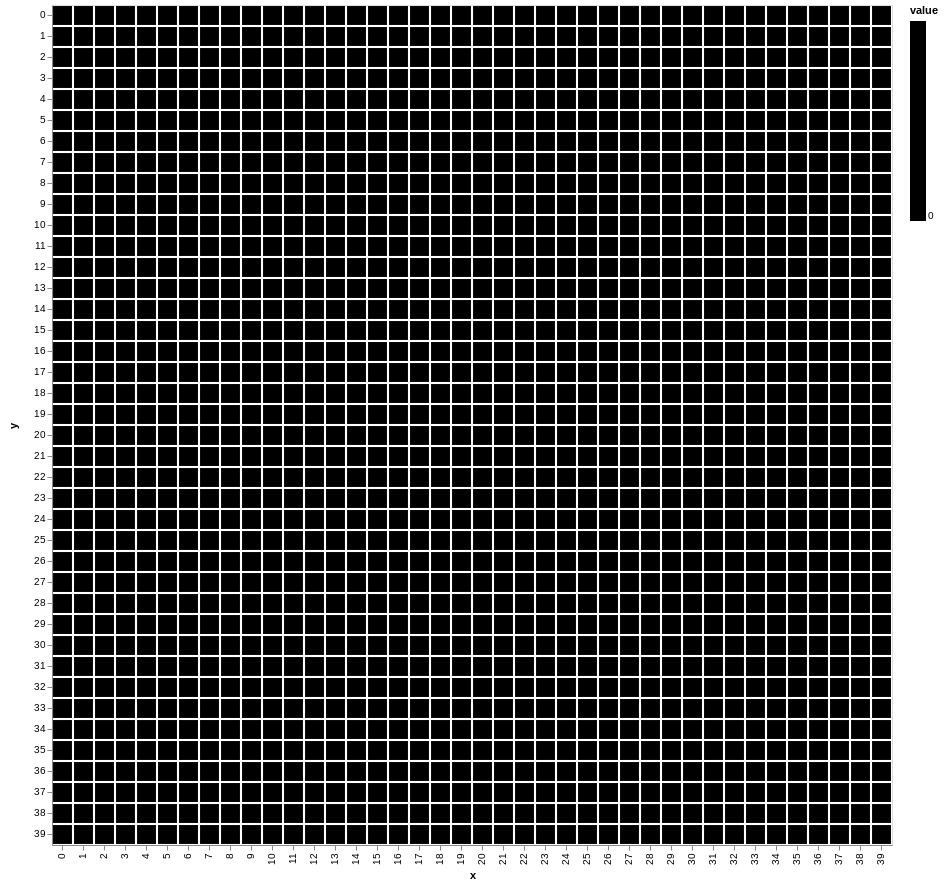

In [4]:
world = w.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated procedurally. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

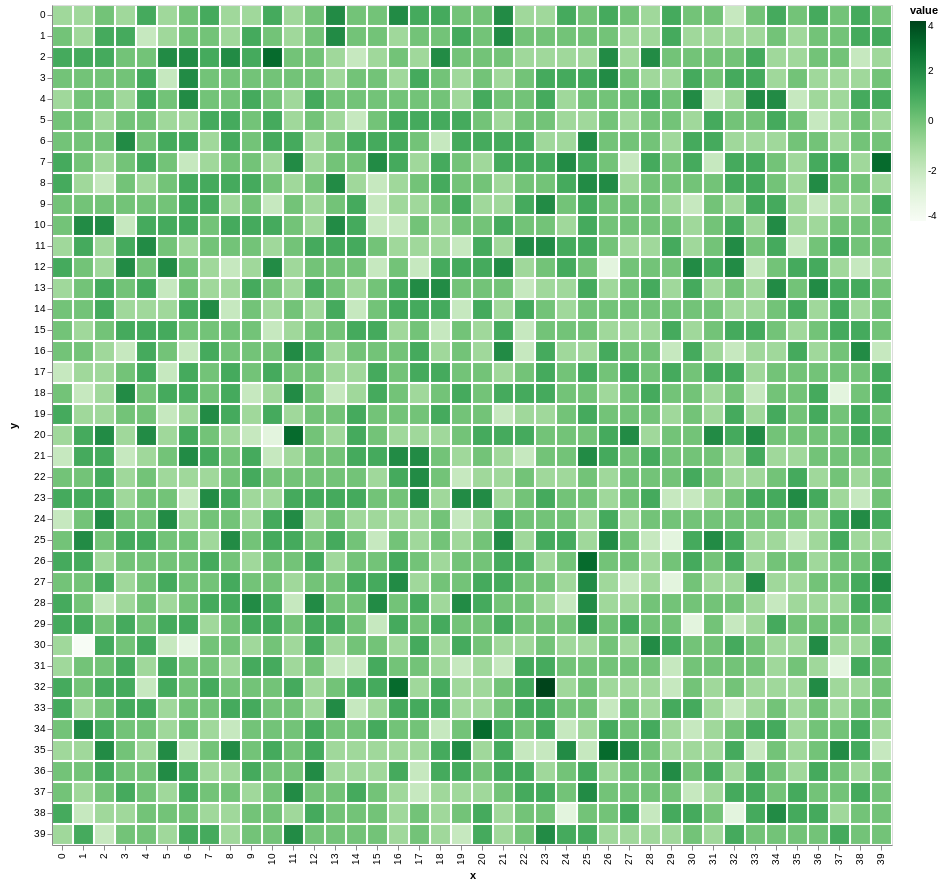

In [5]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [6]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symmetrically.

In [7]:
coord = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", coord)

mdf = world.reindexMountain(coord,m)
mdf

Mountain Placed:  [23 39]


,35,36,37,38,39,40,41,42,43
19,1,1,1,1,1,1,1,1,1
20,1,2,2,2,2,2,2,2,1
21,1,2,3,3,3,3,3,2,1
22,1,2,3,4,4,4,3,2,1
23,1,2,3,4,5,4,3,2,1
24,1,2,3,4,4,4,3,2,1
25,1,2,3,3,3,3,3,2,1
26,1,2,2,2,2,2,2,2,1
27,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

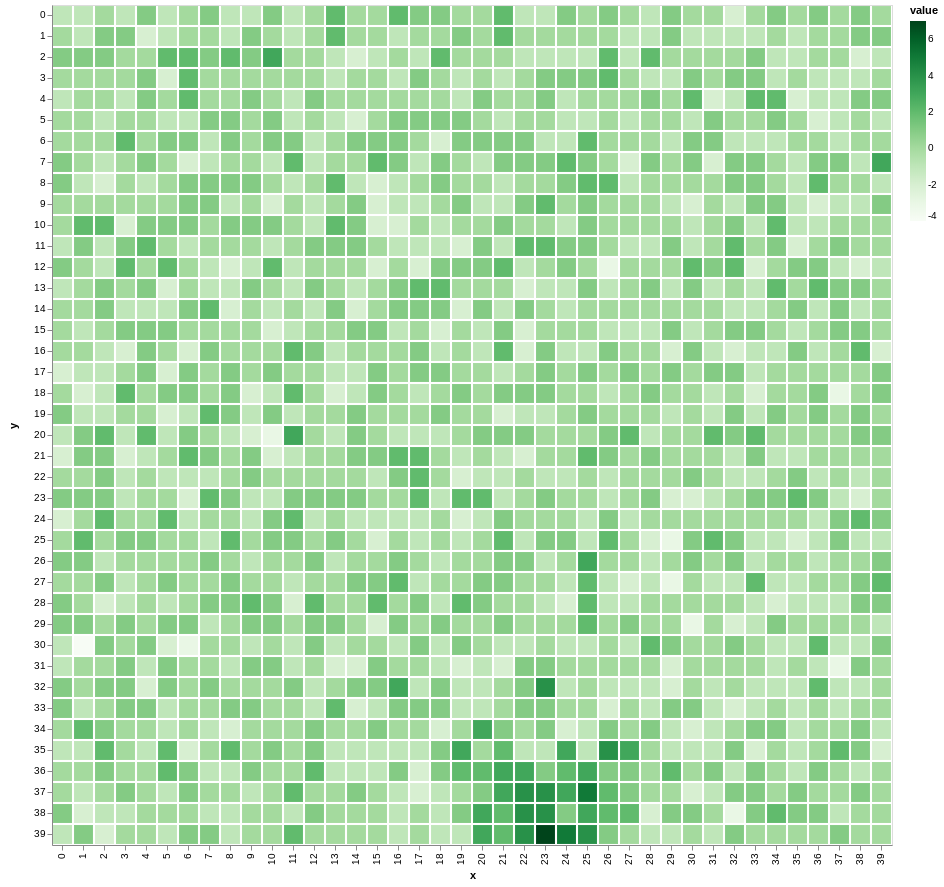

In [8]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board I'll need to create a brownian motion function to drop a mountain and then move. 

In [9]:
world.brownian_land()

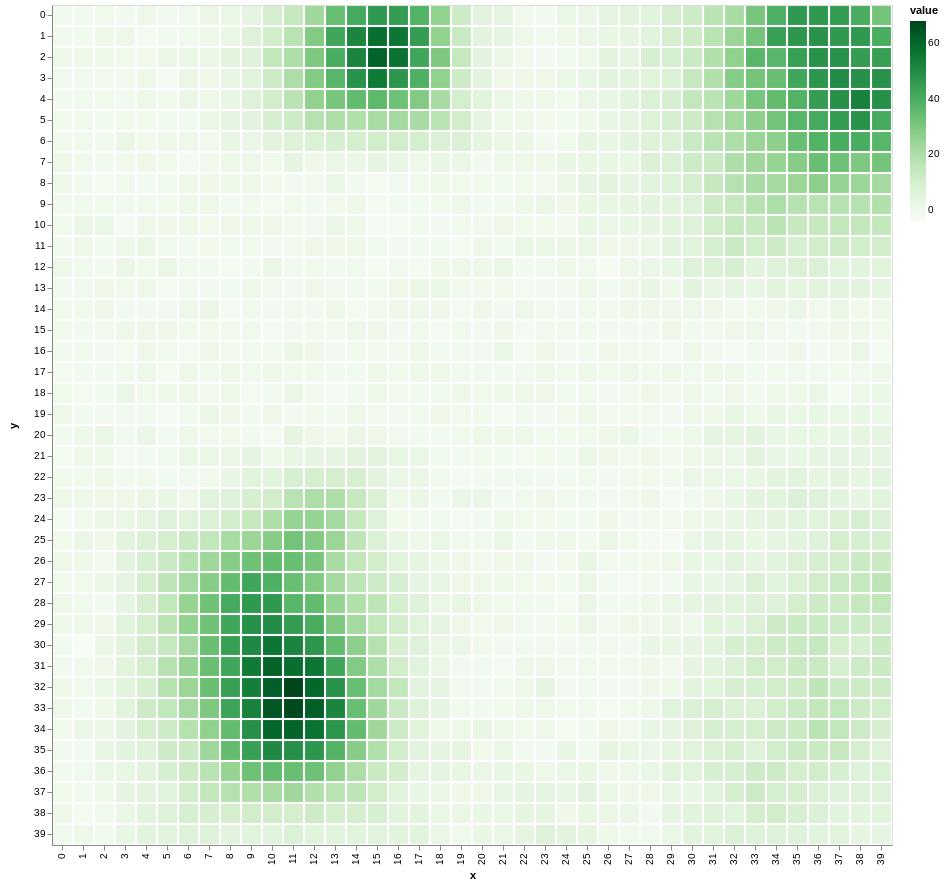

In [10]:
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `height == 0` then you can assume that lower terrain is _under water_

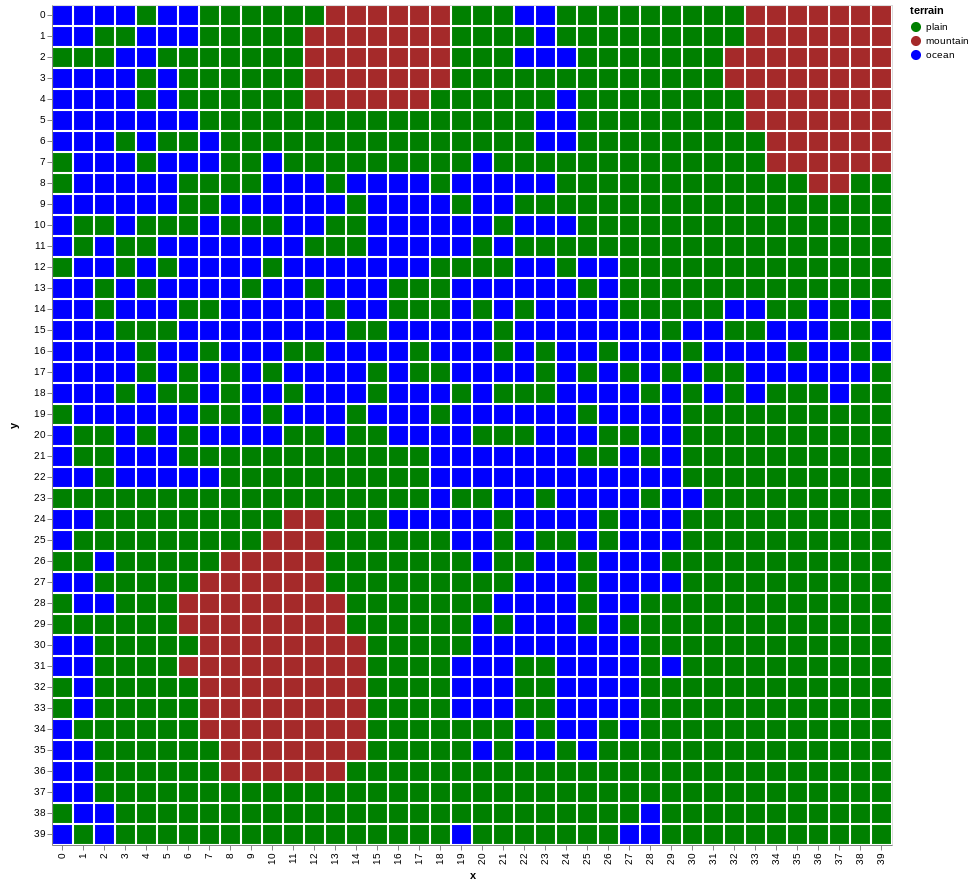

In [11]:
draw.drawTerrainTypes(world.grid_elevation,world.landscape)

### Rainfall

Rainfall makes terrain different. Wet areas become forests. Dry areas become deserts. 

In [12]:
world.brownian_rainfall()

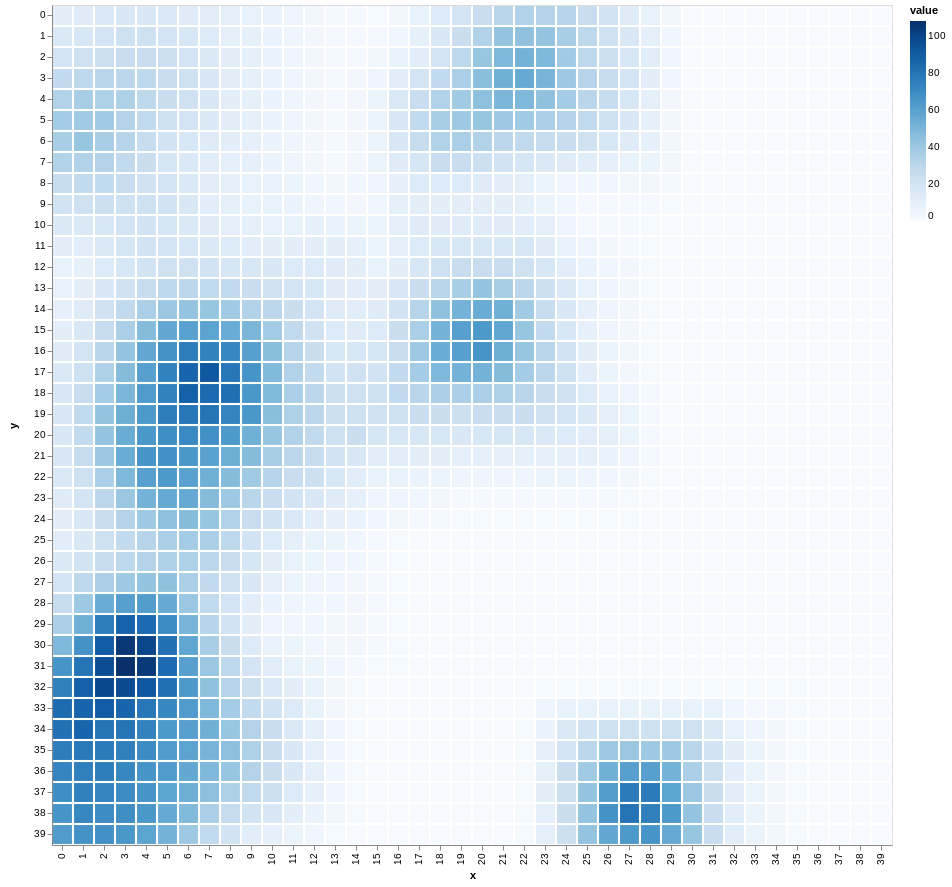

In [13]:
draw.drawRainFall(world.grid_rainfall)

### Build core game features dataframe
This function builds the df_features that will be used later in the actual game. This way you can quickly search and filter the world to find things.

In [14]:
world.build_df_features()

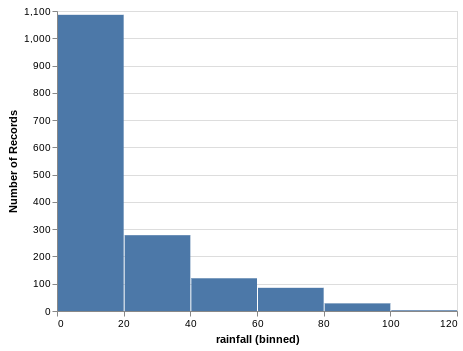

In [15]:
alt.Chart(world.df_features).mark_bar().encode(
    alt.X("rainfall", bin=True),
    y='count()',
)

The amount of rainfal in the world determines if the area will become a forest or a desert. This can be set from the `landscape` parameters. 

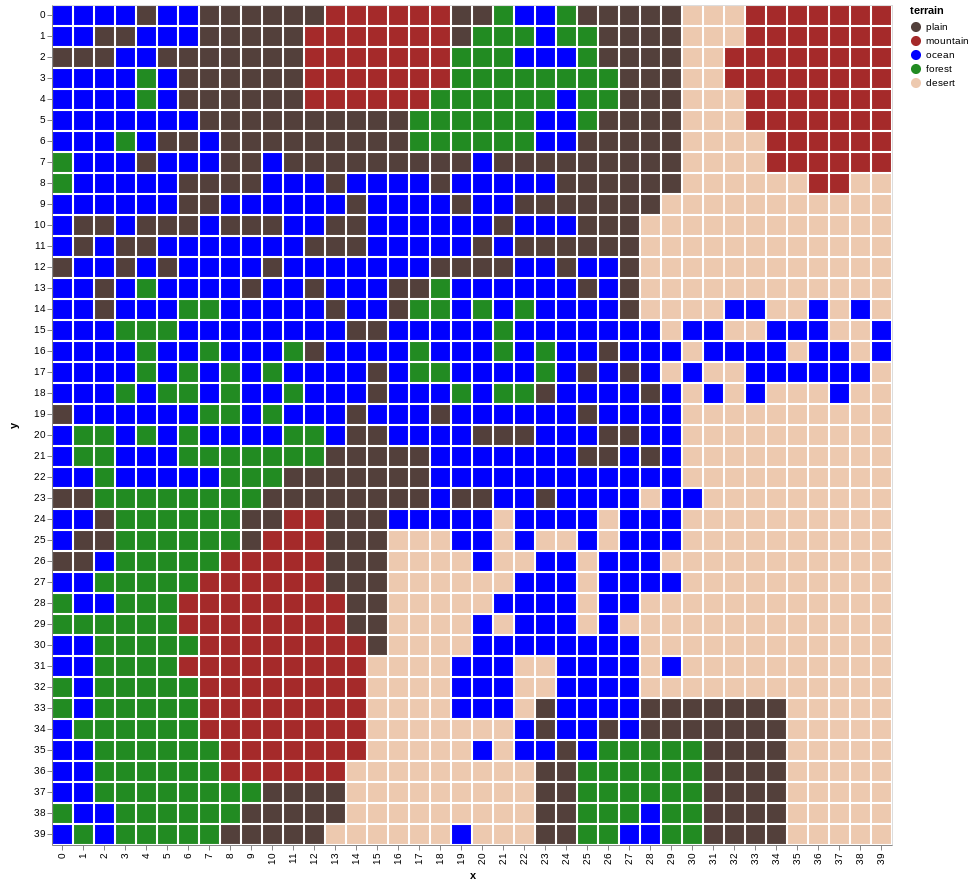

In [16]:
world.df_features['terrain'] = world.df_features.apply(lambda x: w.set_ecology(x,landscape),axis =1 )
draw.drawterrainadvanced(world.df_features)

# The age of the Mortals

The terrain and all of the natural features are formed in the first age. Mountains, rivers, lakes and forests. Once the land has settled, the first cities appear. 

Culture settings come from the user input, there are defaults for everything. Once specified the `.culture` placeholder can be replaced. It should not be used until this point. 


In [17]:
c

<module 'lib.builders.culture' from '../lib/builders/culture.py'>

In [18]:
# the path to the `datasets` folder is different when launched in the Notebook.
culture = c.Culture(paths='notebooks')
world.culture = culture
world.culture.eons

10

## People
A `Person` is a required parameter for many things like `towns`, `nations` and `buildings`

A person requires a `culture` to specify how the names will be generated. As a default the person is a `peon` and exists nowhere (`None`). Optional parameters allow the person to be created with a `role` and a `location`. `Location` can be a `town`, `building` or a `key` where the person can be found. 

In [19]:
people.Person(world.culture,location=world.get_random_chord())

Franettit the commoner

## Towns

the `__init__` method of a city takes a founding age and a location (which can be generated randomly via `World.get_random_chord`). The init method automatically generates a name. The default nation is the name of the town.

In [20]:
new_town = towns.Town(world.get_random_chord(),1,culture,people)
new_town

town of Servantsvale: population: 1 location: [16,32] founded 1

In [21]:
new_town.speaker

Groglan the Speaker of Servantsvale

## The age of civilization

Cities grow for a set number of aeons. During each eon
* n new villages are born
* each village has g% chance to grow

The cities are randomly placed (not in the ocean)

In [22]:
all_towns = towns.build_towns(world,people)
world.towns = all_towns
[(str(p),p.population) for p in all_towns]

[('town of Lilyborourgh: population: 6 location: [35,31] founded 0',
  [Tommur the Speaker of Lilyborourgh,
   Dogordark the commoner,
   Safaddoh the commoner,
   Hejennesh the commoner,
   Droffim the commoner,
   Shenda the commoner]),
 ('town of Servantscoil: population: 5 location: [11,6] founded 1',
  [Wrazoe the Speaker of Servantscoil,
   Zhanoddor the commoner,
   Hatallaker the commoner,
   Alovallunt the commoner,
   Quiyove the commoner]),
 ('town of Lordstear: population: 6 location: [34,35] founded 1',
  [Parushot the Speaker of Lordstear,
   Qualdish the commoner,
   Vogrnan the commoner,
   Fakkelle the commoner,
   Stahand the commoner,
   Ericksun the commoner]),
 ('town of Lionhaven: population: 3 location: [3,25] founded 1',
  [Polsar the Speaker of Lionhaven,
   Thodellnan the commoner,
   Thegroch the commoner]),
 ('town of Fenkeep: population: 2 location: [11,35] founded 2',
  [Zhogrosh the Speaker of Fenkeep, Hejennam the commoner]),
 ('town of Solhammer: popula

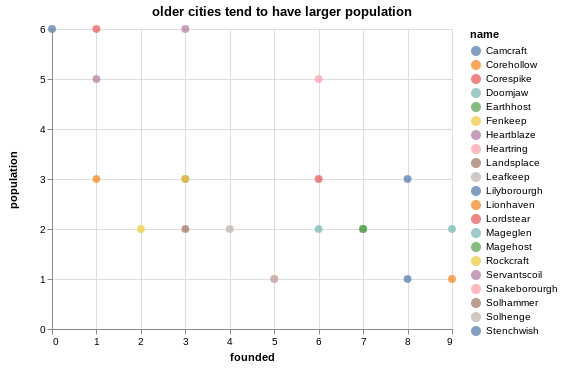

In [23]:
def population_age(towns):
    df = pd.DataFrame(index=range(len(all_towns)))
    df['name'] = [t.name for t in all_towns]
    df['population'] = [t.pop for t in all_towns]
    df['founded'] = [t.founded for t in all_towns]
    return df

alt.Chart(population_age(towns),title="older cities tend to have larger population").mark_circle(size=60).encode(
    y='population',
    x='founded',
    color='name',
    tooltip=['name']
)

## Adding the towns to the map: 

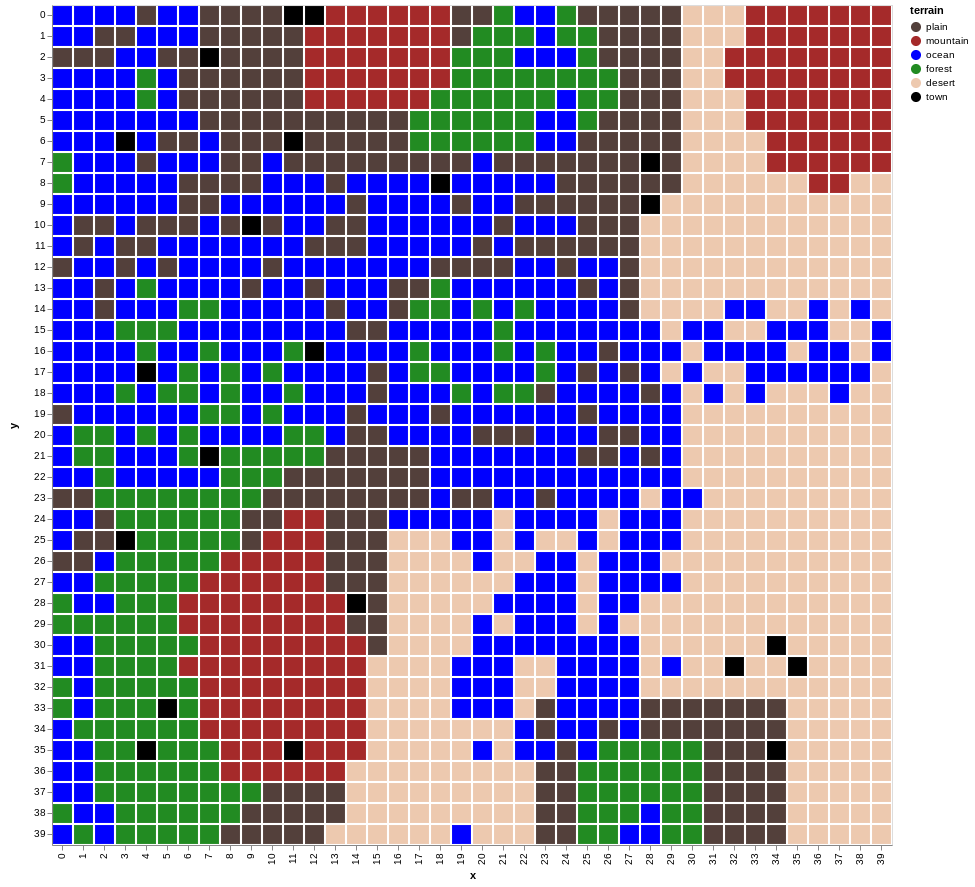

In [24]:
world.add_features(all_towns)
#TODO: Update drawCities to support more terrain types
draw.drawCities(world.df_features)

In [25]:
world.df_features[world.df_features['feature'].isna()==False]

,y,rainfall,x,key,elevation,terrain,feature
key,,,,,,,
11:0,0,5.0,11,11:0,14.0,town,Snakeborourgh
12:0,0,3.0,12,12:0,23.0,town,Heartblaze
7:2,2,15.0,7,7:2,2.0,town,Corehollow
3:6,6,32.0,3,3:6,2.0,town,Corespike
11:6,6,5.0,11,11:6,7.0,town,Servantscoil
28:7,7,6.0,28,28:7,8.0,town,Leafkeep
18:8,8,14.0,18,18:8,1.0,town,Doomjaw
28:9,9,2.0,28,28:9,5.0,town,Solhammer
9:10,10,9.0,9,9:10,1.0,town,Mageglen


# Nations

In [26]:
#k is the actual k_means cluster object.
all_nations,k = nations.cluster_nations(world)
world.nations = all_nations

all_nations

{0: 'Malchild',
 1: 'Leafring',
 2: 'Landscombe',
 3: 'Demonshammer',
 4: 'Ravenhost',
 5: 'Soiljaw',
 6: 'Oakwish',
 7: 'Lilyloch'}

Standard Scikit-Learn stuff

In [27]:
k

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [28]:
world.df_features = nations.predict_nations(k,world)
world.df_features.head(20)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
0:0,0,11.0,0,0:0,-1.0,ocean,NaN,NaN,NaN
1:0,0,13.0,1,1:0,-1.0,ocean,NaN,NaN,NaN
2:0,0,15.0,2,2:0,0.0,ocean,NaN,NaN,NaN
3:0,0,16.0,3,3:0,-1.0,ocean,NaN,NaN,NaN
4:0,0,16.0,4,4:0,1.0,plain,NaN,1.0,Leafring
5:0,0,15.0,5,5:0,-1.0,ocean,NaN,NaN,NaN
6:0,0,13.0,6,6:0,0.0,ocean,NaN,NaN,NaN
7:0,0,12.0,7,7:0,2.0,plain,NaN,1.0,Leafring
8:0,0,9.0,8,8:0,2.0,plain,NaN,1.0,Leafring


The age of conflict is next, so the starting fealty and diplomacy for each town is 1

In [29]:
for t in all_towns:
    try:
        t.set_starting_fielty(world)
    except:
        continue
        
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Servantscoil is loyal to the nation of Leafring
{'nation': 'Leafring', 'national fealty': 1}


In [30]:
#for each nation (n), appoint the most populus city (c) as it's capitol.
for n in np.unique(world.df_features['nation'].dropna()):
    cu = world.df_features[(world.df_features['nation']==n)& \
          (world.df_features['terrain']=='town')]['feature'].tolist()
    #getting the town objects
    ts = [t for t in all_towns if t.name in cu]
    #get population(p)
    p = [t.pop for t in ts]
    #getting the first town that has the max population, make that the capitol
    ts[np.argmax(p)].type='capitol'
    
world.towns

[capitol of Lilyborourgh: population: 6 location: [35,31] founded 0,
 town of Servantscoil: population: 5 location: [11,6] founded 1,
 town of Lordstear: population: 6 location: [34,35] founded 1,
 capitol of Lionhaven: population: 3 location: [3,25] founded 1,
 capitol of Fenkeep: population: 2 location: [11,35] founded 2,
 capitol of Solhammer: population: 3 location: [28,9] founded 3,
 capitol of Heartblaze: population: 6 location: [12,0] founded 3,
 capitol of Landsplace: population: 2 location: [4,35] founded 3,
 town of Rockcraft: population: 3 location: [34,30] founded 3,
 town of Solhenge: population: 2 location: [5,33] founded 4,
 town of Heartring: population: 1 location: [12,16] founded 5,
 town of Leafkeep: population: 1 location: [28,7] founded 5,
 capitol of Mageglen: population: 2 location: [9,10] founded 6,
 town of Snakeborourgh: population: 5 location: [11,0] founded 6,
 town of Corespike: population: 3 location: [3,6] founded 6,
 town of Magehost: population: 2 locat

In [31]:
world.nations = [nations.Nation(n,world,world.culture,people) for n in world.nations.values()]
world.nations

[Nation of Malchild,
 Nation of Leafring,
 Nation of Landscombe,
 Nation of Demonshammer,
 Nation of Ravenhost,
 Nation of Soiljaw,
 Nation of Oakwish,
 Nation of Lilyloch]

In [32]:
world.nations[0].towns

[capitol of Lilyborourgh: population: 6 location: [35,31] founded 0,
 town of Lordstear: population: 6 location: [34,35] founded 1,
 town of Rockcraft: population: 3 location: [34,30] founded 3,
 town of Magehost: population: 2 location: [32,31] founded 7]

In [33]:
world.nations[0].get_capitol().population

[Tommur the Speaker of Lilyborourgh,
 Dogordark the commoner,
 Safaddoh the commoner,
 Hejennesh the commoner,
 Droffim the commoner,
 Shenda the commoner,
 Ereyellal the Ruler of the nation of Malchild]

So the world has nations, nations have towns, and towns have people. Objects all nested together and easy to reference. A nation's capitol will always have two people: the ruler and the speaker. Larger cities will have extra peons. 

In [34]:
world.nations[0].get_capitol().population[0].get_person_data()

{'name': 'Tommur',
 'role': 'Speaker of Lilyborourgh',
 'loyalty': 0.5,
 'temperment': 0.6,
 'attributes': ['alive']}

In [35]:
world.df_features[world.df_features['feature'].isna()==False].sort_values(['nation'])

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
28:9,9,2.0,28,28:9,5.0,town,Solhammer,3.0,Demonshammer
28:7,7,6.0,28,28:7,8.0,town,Leafkeep,3.0,Demonshammer
4:17,17,61.0,4,4:17,1.0,town,Stenchwish,2.0,Landscombe
3:25,25,27.0,3,3:25,5.0,town,Lionhaven,2.0,Landscombe
7:21,21,60.0,7,7:21,2.0,town,Earthhost,2.0,Landscombe
11:0,0,5.0,11,11:0,14.0,town,Snakeborourgh,1.0,Leafring
3:6,6,32.0,3,3:6,2.0,town,Corespike,1.0,Leafring
7:2,2,15.0,7,7:2,2.0,town,Corehollow,1.0,Leafring
12:0,0,3.0,12,12:0,23.0,town,Heartblaze,1.0,Leafring


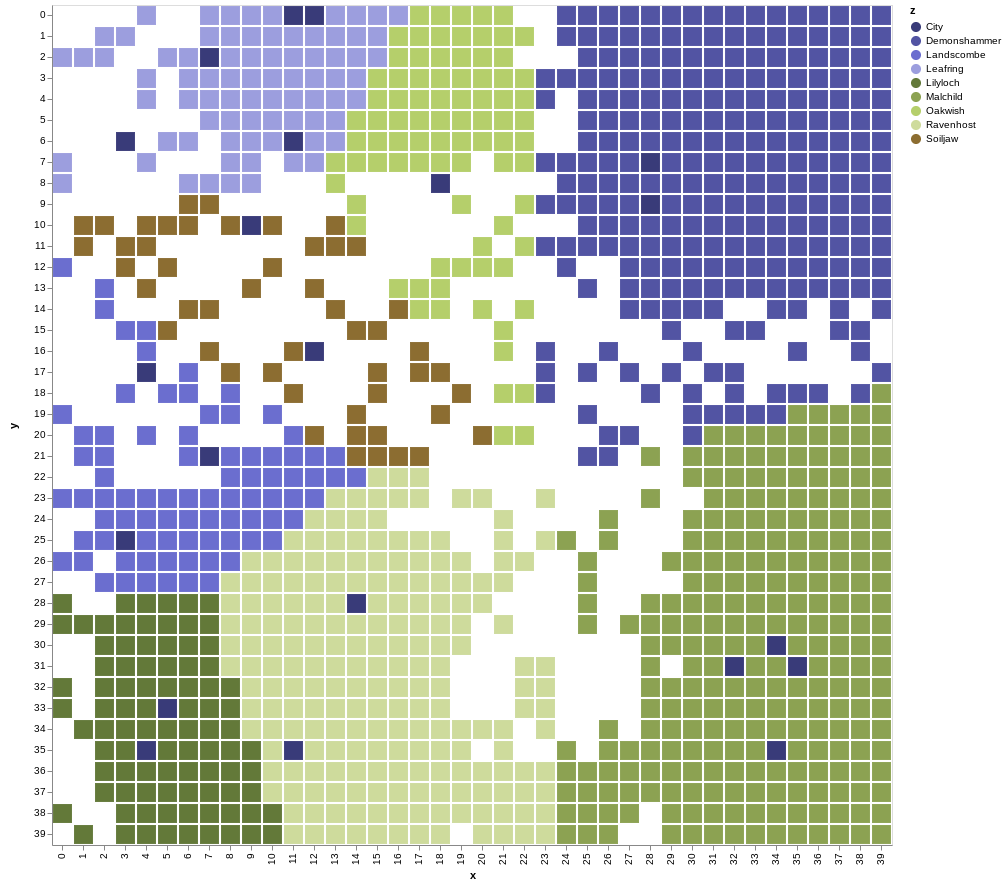

In [36]:
draw.drawboarders(world.df_features)

# The age of the Conflict

The terrain and all of the natural features are formed in the first age. Cities and nations in the second. In the third age chaos will shift the natural order and cause the tension that creates the objectives of the game. 


In [37]:
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Servantscoil is loyal to the nation of Leafring
{'nation': 'Leafring', 'national fealty': 1}


People have loyalty to thier nations, as well as towns. Nations have a loyalty to each other. Towns have speakers, who represent the town. Nations have rulers. 

In [38]:
example_nation = world.nations[1]
print (example_nation.ruler," has a temperment of ",example_nation.ruler.temperment)
print (example_nation.get_capitol().speaker," has a loyalty of ",example_nation.get_capitol().speaker.loyalty)

Kinsort the Ruler of the nation of Leafring  has a temperment of  0.51
Pacarrion the Speaker of Heartblaze  has a loyalty of  0.5


In [39]:
world.get_filtered_chord(t=['plain','mountain','forrest'],n=example_nation.name,r='key')

'11:1'

In [40]:
example_nation.towns

[town of Servantscoil: population: 5 location: [11,6] founded 1,
 capitol of Heartblaze: population: 6 location: [12,0] founded 3,
 town of Snakeborourgh: population: 5 location: [11,0] founded 6,
 town of Corespike: population: 3 location: [3,6] founded 6,
 town of Corehollow: population: 1 location: [7,2] founded 9]

## Swaying favor with other nations

Events cause the relationship to sway between nations. This can be done by passing the `nation` or list of `nation` objects into the `alter_favor` function. 

In [41]:
nations.treaties

,stance,favor
0,sworn enemies,0.0
1,war,0.1
2,tense,0.3
3,peace,0.6
4,allies,0.9


In [42]:
help(nations.alter_favor)

Help on function alter_favor in module lib.builders.nations:

alter_favor(s, o, a)
    s = the target nation(s) (obj or list). s will not change. O's favor of s will change.
    o = the nation(s) (obj or list) who's favor is change. O's favor of s will change
    
    Examples:
    (a,[o]) each nation in o's favor of a is changed by s
    (a,o) o's favor of a is changed by s
    ([a],o) o's favor of each nation in a is changed by s
    s = amount of change (int)
    
    national relationship with itself doesn't decay, but town and person loyalty can.



### example 1: one nation does something that many other nations's don't like. 

In [43]:
s_nation = world.nations[0]
o_nations = world.nations[1:3]
affect = -.25
nations.alter_favor(s_nation,o_nations,affect)

In [44]:
print("subject nations (nations who have done the deed)")
print(f"{s_nation} did something {affect} to {o_nations}")
print(s_nation,"\n",yaml.dump(s_nation.diplomacy))

print("object nations (nations who's favor is affected by the deed)")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in o_nations]


subject nations (nations who have done the deed)
Nation of Malchild did something -0.25 to [Nation of Leafring, Nation of Landscombe]
Nation of Malchild 
 Demonshammer:
  favor: 0.8
  stance: peace
Landscombe:
  favor: 0.8
  stance: peace
Leafring:
  favor: 0.8
  stance: peace
Lilyloch:
  favor: 0.8
  stance: peace
Oakwish:
  favor: 0.8
  stance: peace
Ravenhost:
  favor: 0.8
  stance: peace
Soiljaw:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Leafring 
 Demonshammer:
  favor: 0.8
  stance: peace
Landscombe:
  favor: 0.8
  stance: peace
Lilyloch:
  favor: 0.8
  stance: peace
Malchild:
  favor: 0.55
  stance: tense
Oakwish:
  favor: 0.8
  stance: peace
Ravenhost:
  favor: 0.8
  stance: peace
Soiljaw:
  favor: 0.8
  stance: peace

Nation of Landscombe 
 Demonshammer:
  favor: 0.8
  stance: peace
Leafring:
  favor: 0.8
  stance: peace
Lilyloch:
  favor: 0.8
  stance: peace
Malchild:
  favor: 0.55
  stance: tense
Oakwish:
  favor: 0.

[None, None]

### example 2: several nations does something that annother nation likes. 

In [45]:
s_nations = world.nations[2:4]
o_nation = world.nations[5]
affect = .25

nations.alter_favor(s_nations,o_nation,affect)

In [46]:
print("subject nations (nations who have done the deed)")
print(f"{s_nations} did something {affect} to {o_nation}")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in s_nations]
print("object nations (nations who's favor is affected by the deed)")
print(o_nation,"\n",yaml.dump(o_nation.diplomacy))

subject nations (nations who have done the deed)
[Nation of Landscombe, Nation of Demonshammer] did something 0.25 to Nation of Soiljaw
Nation of Landscombe 
 Demonshammer:
  favor: 0.8
  stance: peace
Leafring:
  favor: 0.8
  stance: peace
Lilyloch:
  favor: 0.8
  stance: peace
Malchild:
  favor: 0.55
  stance: tense
Oakwish:
  favor: 0.8
  stance: peace
Ravenhost:
  favor: 0.8
  stance: peace
Soiljaw:
  favor: 0.8
  stance: peace

Nation of Demonshammer 
 Landscombe:
  favor: 0.8
  stance: peace
Leafring:
  favor: 0.8
  stance: peace
Lilyloch:
  favor: 0.8
  stance: peace
Malchild:
  favor: 0.8
  stance: peace
Oakwish:
  favor: 0.8
  stance: peace
Ravenhost:
  favor: 0.8
  stance: peace
Soiljaw:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Soiljaw 
 Demonshammer:
  favor: 1
  stance: allies
Landscombe:
  favor: 1
  stance: allies
Leafring:
  favor: 0.8
  stance: peace
Lilyloch:
  favor: 0.8
  stance: peace
Malchild:
  favor: 0.8

Events are thier own thing. They aren't `culture` or `landscape`. They happen at the beginning of the game and depending on `culture.chaos` happen when the character moves from area to area. 

In [47]:
e = events.Events(paths="notebooks")

 `culture.eons` determines how many years will pass with a possibility of an event happening. `culture.chaos` determines how likely an event is to occur.

In [56]:
[np.random.choice(np.random.choice(np.random.choice(world.nations).towns).population) for n in range(2)]

In [58]:
def spawn_feature(world,feature):
    key = world.get_filtered_chord(t=['plain','mountain','forest'],
                                   n=example_nation.name,
                                   r='key')
    
feature = {'name':'radercamp',
          'danger':1,
          'bestiary':'rader',
          'boss':True,
          'tenure'}
word.df_features.loc[key,'feature'] = feature

In [57]:
world.nations[1].towns[1].population

'Soiljaw'

In [50]:
world.culture.eons,world.culture.chaos

(10, 0.6)

In [51]:
#now to run through the eons and let fate happen
all_events = events.pass_through_time(world,e.events_df,nations)
all_events

['0: raiders from [Nation of Lilyloch], plundered [Nation of Ravenhost, Nation of Soiljaw, Nation of Malchild]',
 '1: a noble from [Nation of Leafring] was married to a noble in [Nation of Leafring]',
 '2: nothing happend during this period.',
 '3: raiders from [Nation of Soiljaw], plundered [Nation of Lilyloch, Nation of Oakwish, Nation of Leafring]',
 '4: a noble from [Nation of Leafring] was married to a noble in [Nation of Leafring]',
 '5: a noble from [Nation of Lilyloch] was married to a noble in [Nation of Soiljaw]',
 '6: raiders from [Nation of Lilyloch], plundered [Nation of Landscombe, Nation of Ravenhost, Nation of Oakwish]',
 '7: a noble from [Nation of Lilyloch] was married to a noble in [Nation of Soiljaw]',
 '8: nothing happend during this period.',
 '9: raiders from [Nation of Ravenhost], plundered [Nation of Oakwish, Nation of Soiljaw, Nation of Ravenhost]']

# Monsters and Enemies

In [52]:
world.culture.chaos

0.6

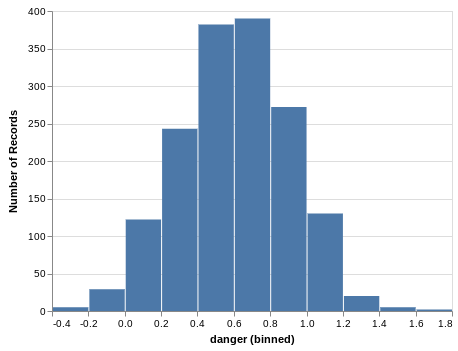

In [53]:
world = events.add_chaos_to_world(world)

alt.Chart(world.df_features).mark_bar().encode(
    alt.X("danger", bin=True),
    y='count()',
)

# Saving the local copy

Saving a local copy of the pickled file for update. TODO: add function to save pickle in S3

In [54]:
world.df_features.head(10)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation,z,danger
key,,,,,,,,,,,
0:0,0,11.0,0,0:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.609
1:0,0,13.0,1,1:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.817
2:0,0,15.0,2,2:0,0.0,ocean,NaN,NaN,NaN,NaN,0.697
3:0,0,16.0,3,3:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.271
4:0,0,16.0,4,4:0,1.0,plain,NaN,1.0,Leafring,Leafring,0.711
5:0,0,15.0,5,5:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.032
6:0,0,13.0,6,6:0,0.0,ocean,NaN,NaN,NaN,NaN,0.154
7:0,0,12.0,7,7:0,2.0,plain,NaN,1.0,Leafring,Leafring,0.277
8:0,0,9.0,8,8:0,2.0,plain,NaN,1.0,Leafring,Leafring,0.478


In [55]:
with open('world.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)